<h1 style="font-family:Rockwell; color:#F7E7CE; background-color:#9459FF; padding:10px; border-radius:300px; text-align:center;">
  CHEST X_RAY CLASSIFICATION
</h1>

<h3 style='font-family:rockwell; color:#ff8150'> Importing Libraries </h3>

In [1]:
import os, random, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess


In [18]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [20]:
# XAI
import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries
import cv2

ModuleNotFoundError: No module named 'lime'

In [21]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

In [22]:
BASE_DIR   = r"D:\Project Comparion\data\Data1"  
TRAIN_DIR  = os.path.join(BASE_DIR, "train")
TEST_DIR   = os.path.join(BASE_DIR, "test")

In [23]:
IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
EPOCHS     = 6

In [24]:
ARTIFACTS_DIR = "artifacts"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

In [25]:
train_gen_raw = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.08,
    height_shift_range=0.08,
    zoom_range=0.12,
    horizontal_flip=True,
    fill_mode="nearest"
).flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",   # 3 classes
    shuffle=True,
    seed=SEED
)

test_gen_raw = ImageDataGenerator().flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",   # 3 classes
    shuffle=False
)

Found 5142 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [26]:
class_names = list(train_gen_raw.class_indices.keys())
NUM_CLASSES = len(class_names)
print("Class mapping:", train_gen_raw.class_indices)

Class mapping: {'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}


<h3 style='font-family:rockwell; color:#ff8150'> CNN Model (RESNET 50) </h3>

In [27]:
# Model: ResNet50 TL (include preprocess inside)

def build_resnet50_tl(num_classes=NUM_CLASSES, img_size=IMG_SIZE):
    inp = layers.Input(shape=img_size + (3,))
    x = layers.Lambda(resnet_preprocess, name="resnet_preprocess")(inp)   # <- internal preprocess
    base = ResNet50(weights="imagenet", include_top=False, input_tensor=x)

    for layer in base.layers:
        layer.trainable = False  # freeze base; unfreeze later if needed

    x = base.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inp, out, name="ResNet50_TL_multiclass")
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    # Tag so XAI knows the model expects raw 0..255 (because preprocess inside)
    model._expects_01 = False
    return model

resnet = build_resnet50_tl()

In [28]:
ckpt = os.path.join(ARTIFACTS_DIR, "ResNet50_TL_best.keras")
callbacks = [
    EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=2, min_lr=1e-7, verbose=1),
    ModelCheckpoint(ckpt, monitor="val_accuracy", save_best_only=True, verbose=1)
]

In [29]:
history = resnet.fit(
    train_gen_raw,
    validation_data=test_gen_raw,     # (simple split; if you have a val dir, use that instead)
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/6
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6426 - loss: 1.0223
Epoch 1: val_accuracy improved from None to 0.89286, saving model to artifacts\ResNet50_TL_best.keras
161/161 ━━━━━━━━━━━━━━━━━━━━ 504s 3s/step - accuracy: 0.7620 - loss: 0.6302 - val_accuracy: 0.8929 - val_loss: 0.2614 - learning_rate: 1.0000e-04
Epoch 2/6
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8855 - loss: 0.2967
Epoch 2: val_accuracy improved from 0.89286 to 0.90683, saving model to artifacts\ResNet50_TL_best.keras
161/161 ━━━━━━━━━━━━━━━━━━━━ 416s 3s/step - accuracy: 0.8940 - loss: 0.2742 - val_accuracy: 0.9068 - val_loss: 0.2118 - learning_rate: 1.0000e-04
Epoch 3/6
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9080 - loss: 0.2392
Epoch 3: val_accuracy did not improve from 0.90683
161/161 ━━━━━━━━━━━━━━━━━━━━ 425s 3s/step - accuracy: 0.9103 - loss: 0.2409 - val_accuracy: 0.8851 - val_loss: 0.2930 - learning_rate: 1.0000e-04
Epoch 4/6
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - 

In [31]:
# Save final
final_path = os.path.join(ARTIFACTS_DIR, "ResNet50_TL_final.keras")

resnet.save(
    final_path,save_format="keras" 
)

with open(os.path.join(ARTIFACTS_DIR, "ResNet50_TL_history.json"), "w") as f:
    json.dump({k:[float(x) for x in v] for k,v in history.history.items()}, f, indent=2)

<h3 style='font-family:rockwell; color:#ff8150'> Performance (ACCURACY) </h3>

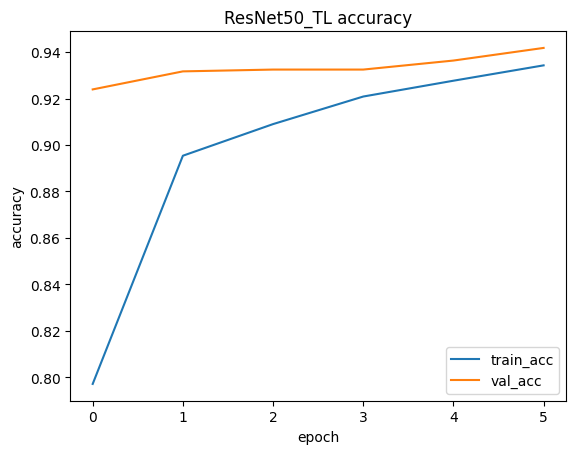

In [10]:
# Plot acc
plt.figure()
plt.plot(history.history.get("accuracy", []), label="train_acc")
plt.plot(history.history.get("val_accuracy", []), label="val_acc")
plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.legend()
plt.title("ResNet50_TL accuracy")
plt.savefig(os.path.join(ARTIFACTS_DIR, "ResNet50_TL_acc.png"), dpi=150)
plt.show()
plt.close()

<h3 style='font-family:rockwell; color:#ff8150'> ACCURACY & LOSS </h3>

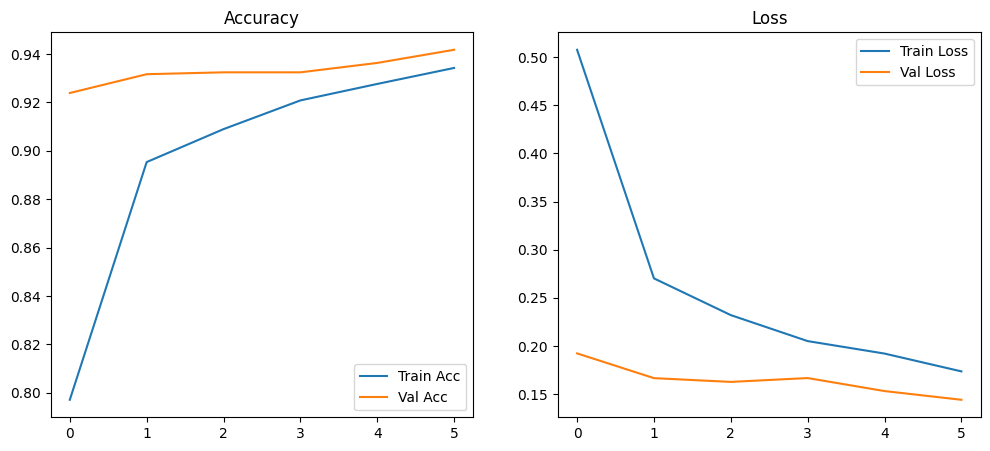

In [ ]:

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.legend(); plt.title("Accuracy")
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend(); plt.title("Loss")
plt.show()

In [16]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

<h3 style='font-family:rockwell; color:#ff8150'> Performance SCORE </h3>

In [ ]:
def evaluate_model_multiclass(model, generator, title="Model"):
    generator.reset()
    y_prob = model.predict(generator, verbose=0)               # shape (N, C)
    y_pred = np.argmax(y_prob, axis=1)
    y_true = generator.classes

    acc = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n📊 {title} Results")
    print("Accuracy:", acc)
    print(report)
    print("Confusion Matrix:\n", cm)

    # Save CM
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.title(f"{title} Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(os.path.join(ARTIFACTS_DIR, f"{title}_cm.png"), dpi=150)
    plt.close()

    return acc, report, cm, y_true, y_pred, y_prob

acc, report, cm, y_true, y_pred, y_prob = evaluate_model_multiclass(resnet, test_gen_raw, "ResNet50_TL")


📊 ResNet50_TL Results
Accuracy: 0.9417701863354038
              precision    recall  f1-score   support

     COVID19     1.0000    0.8966    0.9455       116
      NORMAL     0.8499    0.9464    0.8955       317
   PNEUMONIA     0.9735    0.9462    0.9597       855

    accuracy                         0.9418      1288
   macro avg     0.9411    0.9297    0.9335      1288
weighted avg     0.9455    0.9418    0.9426      1288

Confusion Matrix:
 [[104   7   5]
 [  0 300  17]
 [  0  46 809]]


<h3 style='font-family:rockwell; color:#ff8150'> PRECISION - RECALL - F1-SCORE COMPARION </h3>

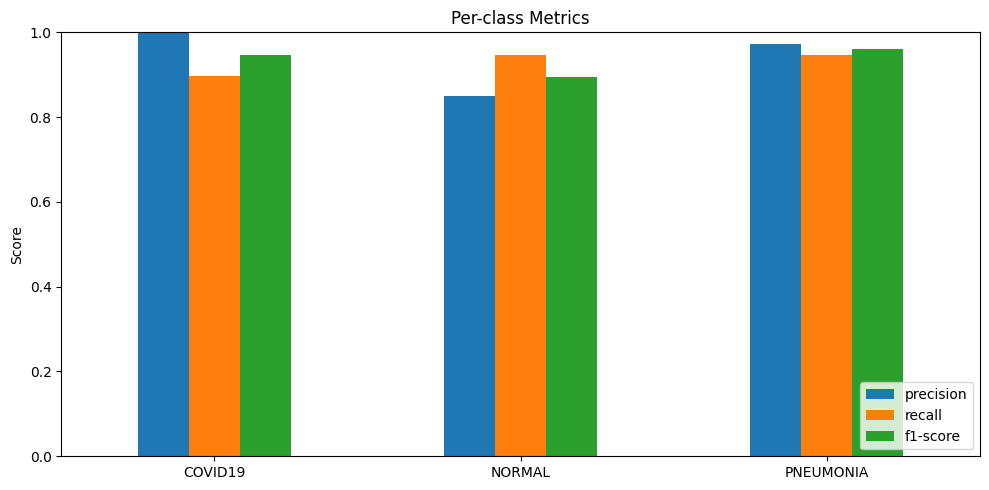

In [ ]:
def plot_classification_report(report_dict, save_dir=ARTIFACTS_DIR):
    df = pd.DataFrame(report_dict).transpose().iloc[:-3, :]  # remove accuracy, macro avg, weighted avg
    df[['precision','recall','f1-score']].plot(kind="bar", figsize=(10,5))
    plt.title("Per-class Metrics")
    plt.ylabel("Score")
    plt.xticks(rotation=0)
    plt.ylim(0,1)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "per_class_metrics.png"), dpi=150)
    plt.show()

report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
plot_classification_report(report_dict)

<h3 style='font-family:rockwell; color:#ff8150'> ROC CURVE </h3>

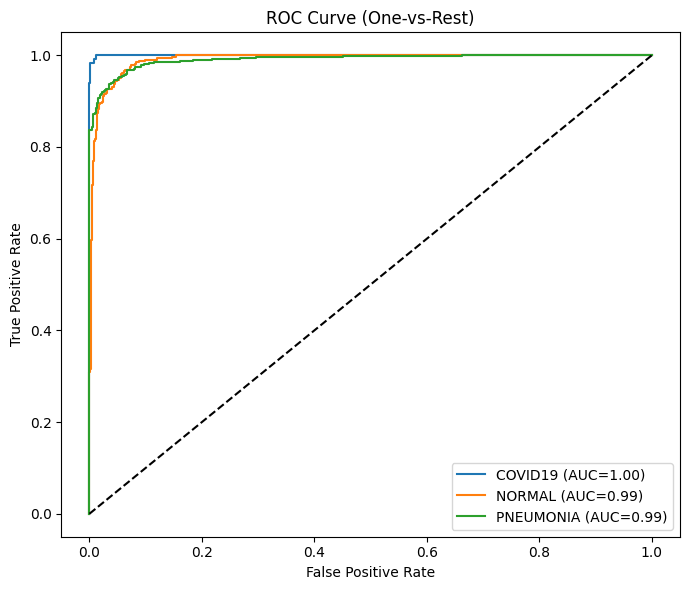

In [ ]:
def plot_roc(y_true, y_prob, save_dir=ARTIFACTS_DIR):
    plt.figure(figsize=(7,6))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve((y_true==i).astype(int), y_prob[:,i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_name} (AUC={roc_auc:.2f})")
    plt.plot([0,1],[0,1],"k--")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (One-vs-Rest)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "roc_curve.png"), dpi=150)
    plt.show()

plot_roc(y_true, y_prob)

<h3 style='font-family:rockwell; color:#ff8150'> PRECISION RECALL CURVE </h3>

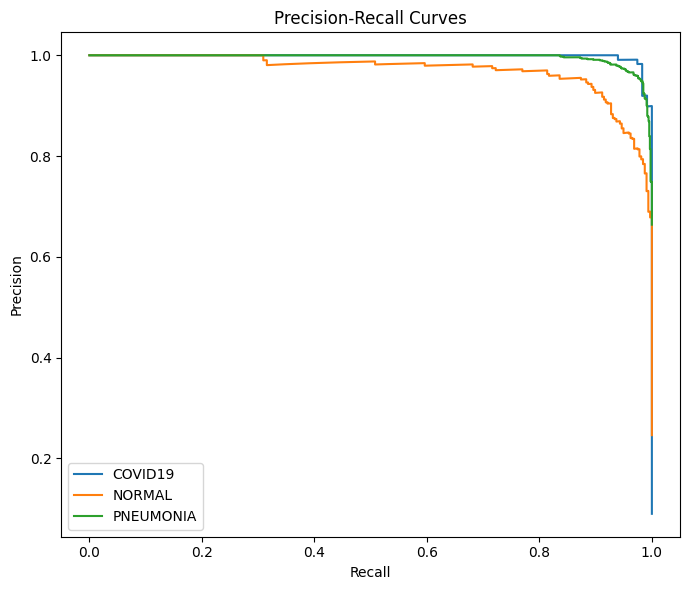

In [ ]:
def plot_pr_curves(y_true, y_prob, save_dir=ARTIFACTS_DIR):
    plt.figure(figsize=(7,6))
    for i, class_name in enumerate(class_names):
        precision, recall, _ = precision_recall_curve((y_true==i).astype(int), y_prob[:,i])
        plt.plot(recall, precision, label=f"{class_name}")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title("Precision-Recall Curves")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "pr_curves.png"), dpi=150)
    plt.show()

plot_pr_curves(y_true, y_prob)

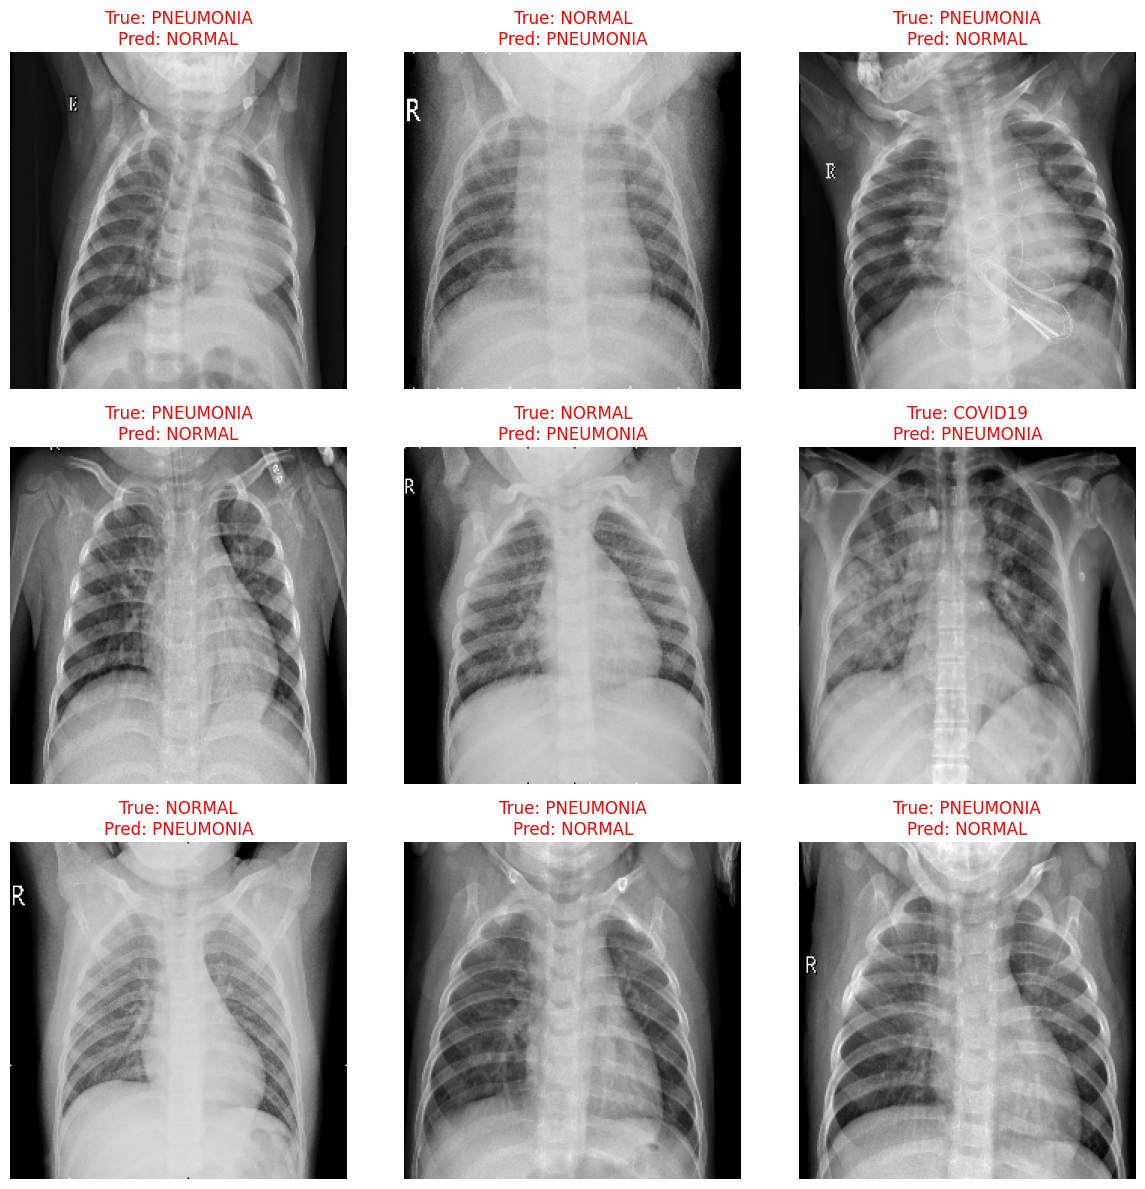

In [ ]:
def show_misclassified(generator, y_true, y_pred, n=9, save_dir=ARTIFACTS_DIR):
    mis_idx = np.where(y_true != y_pred)[0]
    if len(mis_idx)==0:
        print("✅ No misclassifications found!")
        return
    np.random.shuffle(mis_idx)
    take = mis_idx[:n]

    paths = [os.path.join(generator.directory, f) for f in generator.filenames]
    plt.figure(figsize=(12,12))
    for j,i in enumerate(take):
        img = keras.utils.load_img(paths[i], target_size=IMG_SIZE)
        plt.subplot(3,3,j+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"True: {class_names[y_true[i]]}\nPred: {class_names[y_pred[i]]}", color="red")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "misclassified_samples.png"), dpi=150)
    plt.show()

show_misclassified(test_gen_raw, y_true, y_pred)

<h3 style='font-family:rockwell; color:#ff8150'> CONFUSION MATRIX </h3>

✅ Confusion matrix saved at artifacts\ResNet50_TL_cm.png


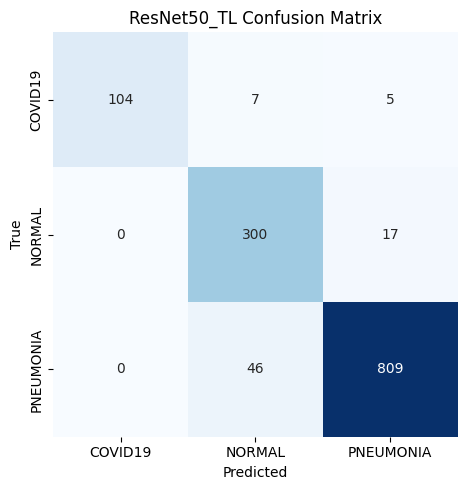

In [ ]:
def plot_confusion_matrix(cm, class_names, title="Confusion Matrix", save_path=None):
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names,
                cbar=False, square=True)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150)
        print(f"✅ Confusion matrix saved at {save_path}")
    plt.show()

# Example usage with your results
plot_confusion_matrix(
    cm,
    class_names,
    title="ResNet50_TL Confusion Matrix",
    save_path=os.path.join(ARTIFACTS_DIR, "ResNet50_TL_cm.png")
)


<h3 style='font-family:rockwell; color:#ff8150'> GRAD CAM Visualization </h3>

In [ ]:
# Prepare a few raw test images (uint8) for XAI (consistent order with generator)
def load_raw_images_from_gen(gen, base_dir, max_n=6):
    paths = [os.path.join(base_dir, f) for f in gen.filenames]
    take = min(max_n, len(paths))
    imgs, labs = [], []
    for i in range(take):
        p = paths[i]
        img = keras.utils.load_img(p, target_size=IMG_SIZE)
        arr = keras.utils.img_to_array(img).astype("uint8")  # raw 0..255
        imgs.append(arr)
        labs.append(gen.classes[i])
    return np.stack(imgs), np.array(labs)

raw_images, raw_labels = load_raw_images_from_gen(test_gen_raw, TEST_DIR, max_n=6)

In [25]:
def find_last_conv(model):
    for layer in reversed(model.layers):
        if isinstance(layer, layers.Conv2D) or layer.__class__.__name__ == "DepthwiseConv2D":
            return layer.name
    raise ValueError("No conv layer found")

In [26]:
def gradcam_multi(model, img_uint8, class_index=None):
    # img_uint8: (H,W,3) uint8
    # model expects raw -> preprocess in Lambda
    x = img_uint8.astype("float32")
    x = np.expand_dims(x, axis=0)

    last_conv = find_last_conv(model)
    grad_model = keras.Model([model.inputs],
                             [model.get_layer(last_conv).output, model.output])

In [27]:
def gradcam_multi(model, img_uint8, class_index=None):
    # img_uint8: (H,W,3) uint8
    # model expects raw -> preprocess in Lambda
    x = img_uint8.astype("float32")
    x = np.expand_dims(x, axis=0)

    last_conv = find_last_conv(model)
    grad_model = keras.Model([model.inputs],
                             [model.get_layer(last_conv).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(x, training=False)
        if class_index is None:
            class_index = tf.argmax(preds[0])
        loss = preds[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    heatmap = tf.image.resize(heatmap[..., None], (img_uint8.shape[0], img_uint8.shape[1])).numpy().squeeze()
    return heatmap

In [28]:
def save_and_show_gradcam_plots(model, images_uint8, labels, prefix="gradcam", model_name="ResNet50_TL"):
    outdir = os.path.join(ARTIFACTS_DIR, prefix)
    os.makedirs(outdir, exist_ok=True)
    for i in range(len(images_uint8)):
        img = images_uint8[i]
        # explain top-predicted class for that image
        x = np.expand_dims(img.astype("float32"), axis=0)
        probs = model.predict(x, verbose=0)[0]
        top_idx = int(np.argmax(probs))

        heat = gradcam_multi(model, img, class_index=top_idx)
        cmap = plt.get_cmap("jet")
        colored = (cmap(heat)[:,:,:3]*255).astype("uint8")
        overlay = (0.4*colored + 0.6*img).astype("uint8")

        plt.figure(figsize=(9,3))
        plt.subplot(1,3,1); plt.imshow(img.astype("uint8")); plt.title("Original"); plt.axis("off")
        plt.subplot(1,3,2); plt.imshow(heat, cmap="jet"); plt.title(f"Heatmap ({class_names[top_idx]})"); plt.axis("off")
        plt.subplot(1,3,3); plt.imshow(overlay); plt.title("Overlay"); plt.axis("off")
        plt.tight_layout()

        fname = os.path.join(outdir, f"{model_name}_gradcam_{i}.png")
        plt.savefig(fname, dpi=150); plt.show()
        print("Saved and displayed Grad-CAM:", fname)

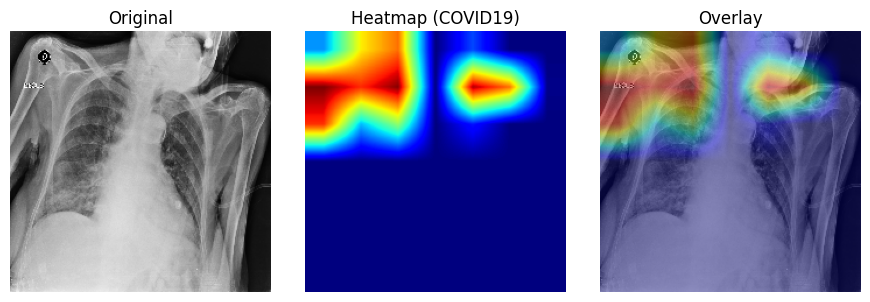

Saved and displayed Grad-CAM: artifacts\gradcam\ResNet50_TL_gradcam_0.png


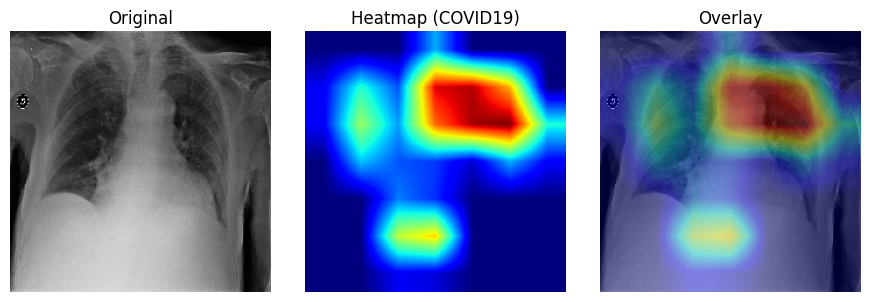

Saved and displayed Grad-CAM: artifacts\gradcam\ResNet50_TL_gradcam_1.png


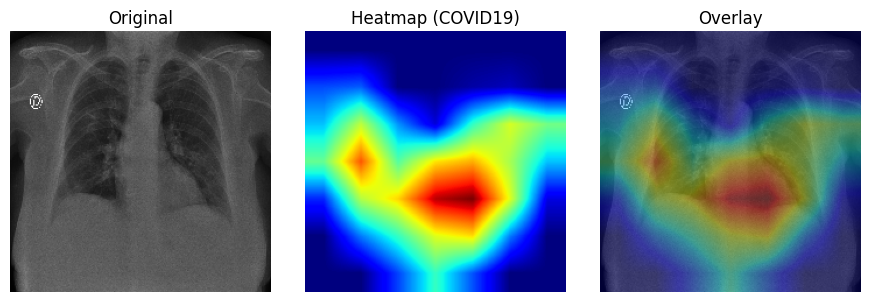

Saved and displayed Grad-CAM: artifacts\gradcam\ResNet50_TL_gradcam_2.png


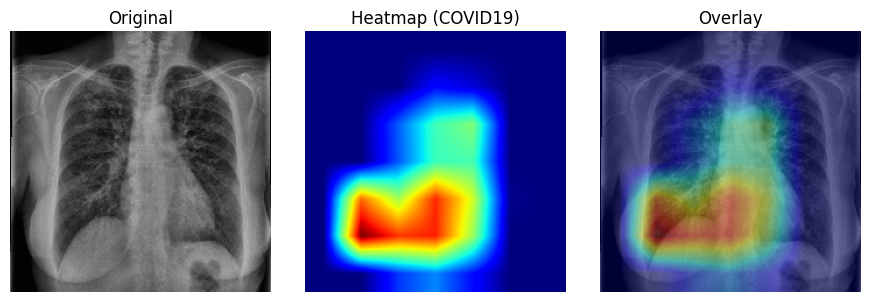

Saved and displayed Grad-CAM: artifacts\gradcam\ResNet50_TL_gradcam_3.png


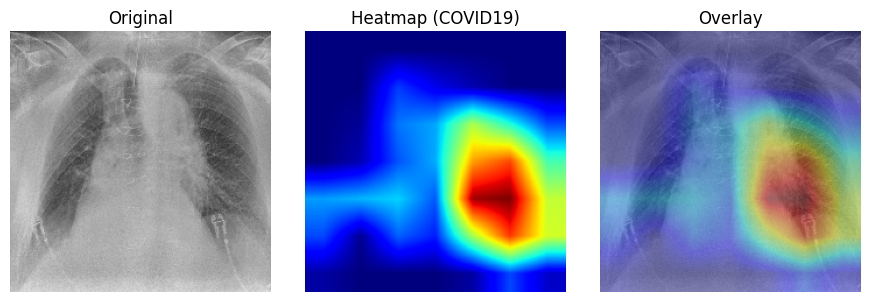

Saved and displayed Grad-CAM: artifacts\gradcam\ResNet50_TL_gradcam_4.png


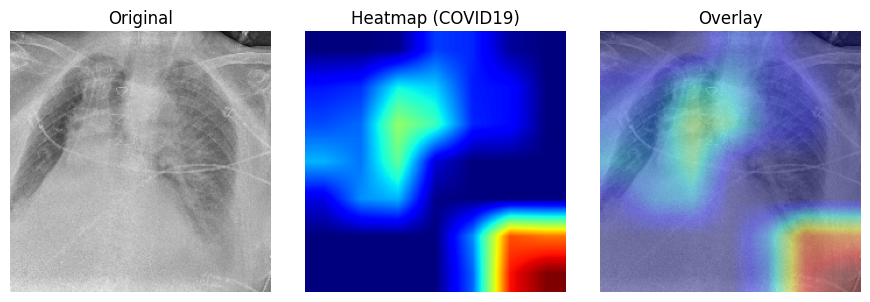

Saved and displayed Grad-CAM: artifacts\gradcam\ResNet50_TL_gradcam_5.png


In [ ]:
save_and_show_gradcam_plots(resnet, raw_images, raw_labels, prefix="gradcam", model_name="ResNet50_TL")

<h3 style='font-family:rockwell; color:#ff8150'> LIME </h3>

  0%|          | 0/400 [00:00<?, ?it/s]

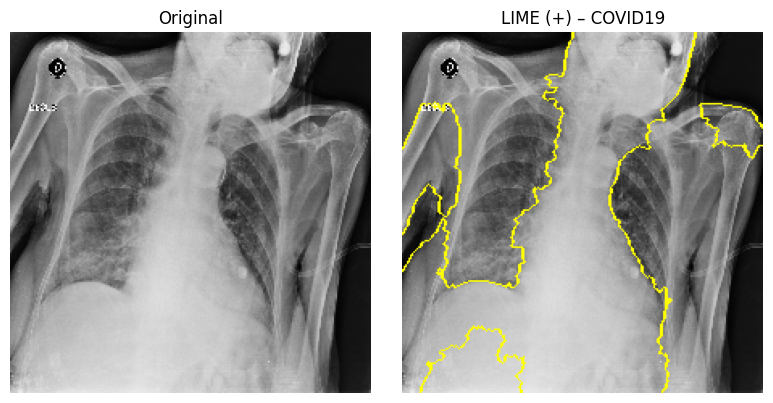

Saved LIME: artifacts\lime\ResNet50_TL_lime_0.png


  0%|          | 0/400 [00:00<?, ?it/s]

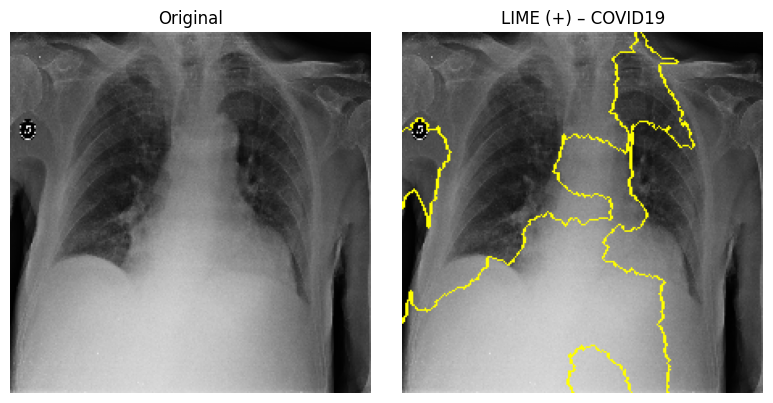

Saved LIME: artifacts\lime\ResNet50_TL_lime_1.png


  0%|          | 0/400 [00:00<?, ?it/s]

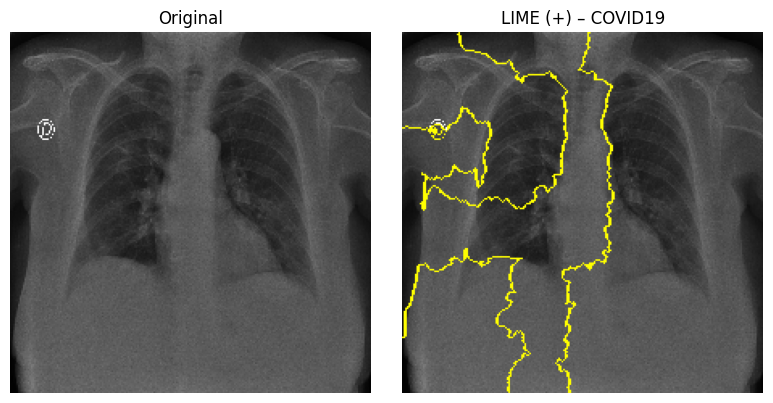

Saved LIME: artifacts\lime\ResNet50_TL_lime_2.png


  0%|          | 0/400 [00:00<?, ?it/s]

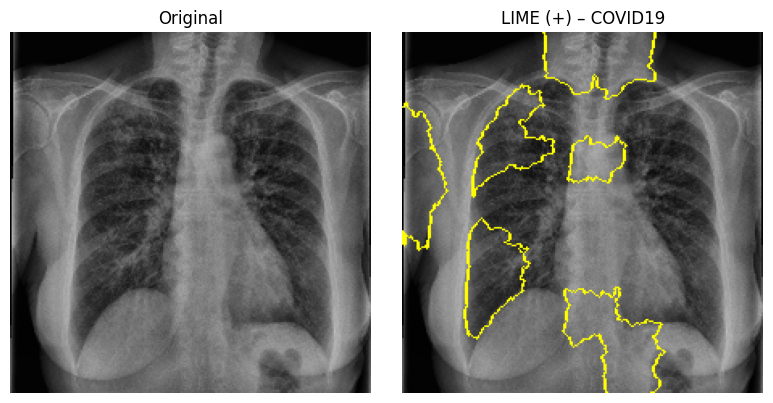

Saved LIME: artifacts\lime\ResNet50_TL_lime_3.png


  0%|          | 0/400 [00:00<?, ?it/s]

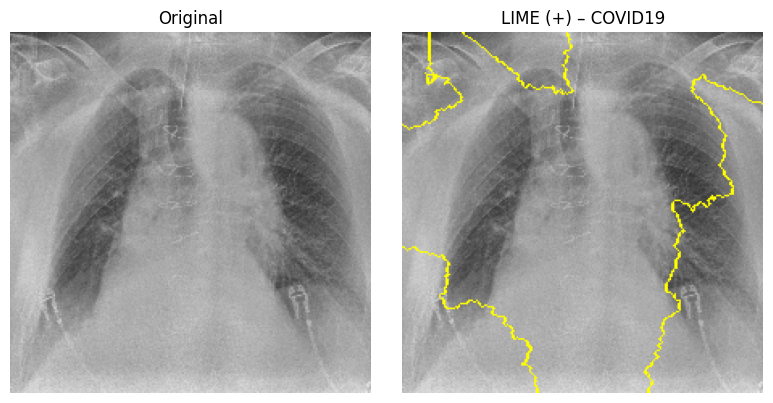

Saved LIME: artifacts\lime\ResNet50_TL_lime_4.png


  0%|          | 0/400 [00:00<?, ?it/s]

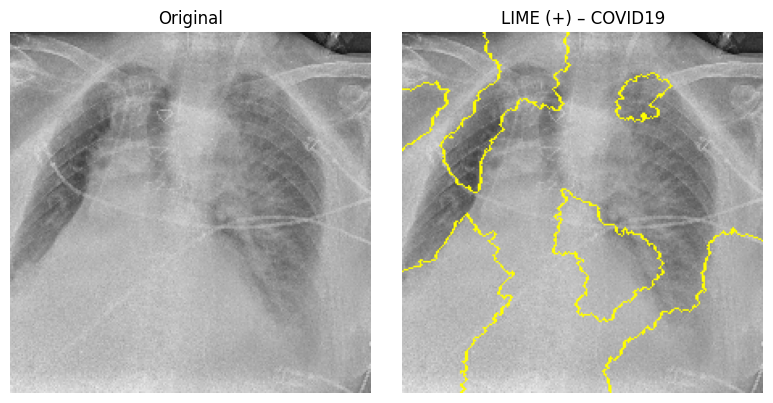

Saved LIME: artifacts\lime\ResNet50_TL_lime_5.png


In [ ]:
def lime_predict_fn_multiclass(imgs):
    x = np.array(imgs).astype("float32")  # raw to float, preprocess handled in model
    preds = resnet.predict(x, verbose=0)  # (N, C) softmax
    return preds

def run_lime_multiclass(images_uint8, num_samples=400, model_name="ResNet50_TL"):
    explainer = lime_image.LimeImageExplainer()
    outdir = os.path.join(ARTIFACTS_DIR, "lime")
    os.makedirs(outdir, exist_ok=True)

    for i, img in enumerate(images_uint8):
        explanation = explainer.explain_instance(
            img, lime_predict_fn_multiclass, top_labels=1,
            hide_color=0, num_samples=num_samples
        )
        top = explanation.top_labels[0]
        temp, mask = explanation.get_image_and_mask(
            label=top, positive_only=True, num_features=8, hide_rest=False
        )
        out = mark_boundaries(temp.astype("uint8"), mask)

        plt.figure(figsize=(8,4))
        plt.subplot(1,2,1); plt.imshow(img.astype("uint8")); plt.title("Original"); plt.axis("off")
        plt.subplot(1,2,2); plt.imshow(out); plt.title(f"LIME (+) – {class_names[top]}"); plt.axis("off")
        plt.tight_layout()
        fname = os.path.join(outdir, f"{model_name}_lime_{i}.png")
        plt.savefig(fname, dpi=150); plt.show()
        print("Saved LIME:", fname)

run_lime_multiclass(raw_images, num_samples=400, model_name="ResNet50_TL")

<h3 style='font-family:rockwell; color:#ff8150'> SHAP </h3>

In [ ]:
def make_predict_fn_multiclass(model):
    def _predict(imgs_uint8):
        x = np.array(imgs_uint8).astype("float32")  # raw to float; model has preprocess
        p = model.predict(x, verbose=0)             # (N, C)
        return p
    return _predict

In [ ]:
def run_shap_partition_multiclass(model, raw_uint8_images, model_name="ResNet50_TL",
                                  max_images=6, max_evals=800,
                                  save_dir=os.path.join(ARTIFACTS_DIR, "shap")):
    os.makedirs(save_dir, exist_ok=True)
    n = min(max_images, raw_uint8_images.shape[0])
    imgs = raw_uint8_images[:n].copy()

    masker = shap.maskers.Image("inpaint_telea", imgs[0].shape)
    predict_fn = make_predict_fn_multiclass(model)
    explainer = shap.Explainer(predict_fn, masker, algorithm="partition", output_names=class_names)

    print(f"[SHAP] Explaining {n} images for {model_name} ...")
    shap_values = explainer(imgs, max_evals=max_evals, batch_size=1)

    # Plot per image (multi-class panel)
    for i in range(n):
        plt.figure()
        shap.image_plot(shap_values[i], show=False)
        plt.suptitle(f"{model_name} – SHAP (sample {i})", y=1.02)
        out_path = os.path.join(save_dir, f"{model_name}_shap_{i}.png")
        plt.savefig(out_path, dpi=150, bbox_inches="tight"); plt.show(); plt.close()
        print("Saved:", out_path)

[SHAP] Explaining 6 images for ResNet50_TL ...


  0%|          | 0/798 [00:00<?, ?it/s]

PartitionExplainer explainer:  17%|█▋        | 1/6 [00:00<?, ?it/s]

  0%|          | 0/798 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 3/6 [04:25<03:29, 69.86s/it]

  0%|          | 0/798 [00:00<?, ?it/s]

PartitionExplainer explainer:  67%|██████▋   | 4/6 [07:30<03:55, 117.81s/it]

  0%|          | 0/798 [00:00<?, ?it/s]

PartitionExplainer explainer:  83%|████████▎ | 5/6 [11:04<02:33, 153.92s/it]

  0%|          | 0/798 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 6/6 [14:54<00:00, 180.35s/it]

  0%|          | 0/798 [00:00<?, ?it/s]

PartitionExplainer explainer: 7it [19:07, 191.21s/it]                       


<Figure size 640x480 with 0 Axes>

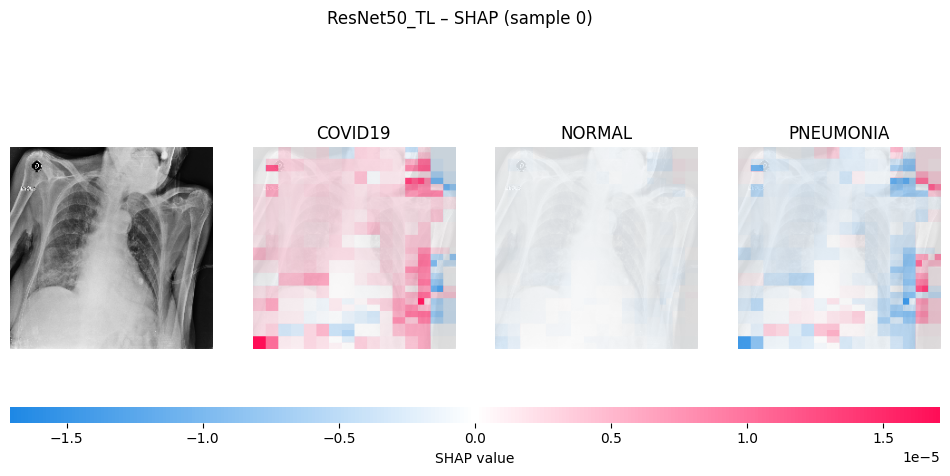

Saved: artifacts\shap\ResNet50_TL_shap_0.png


<Figure size 640x480 with 0 Axes>

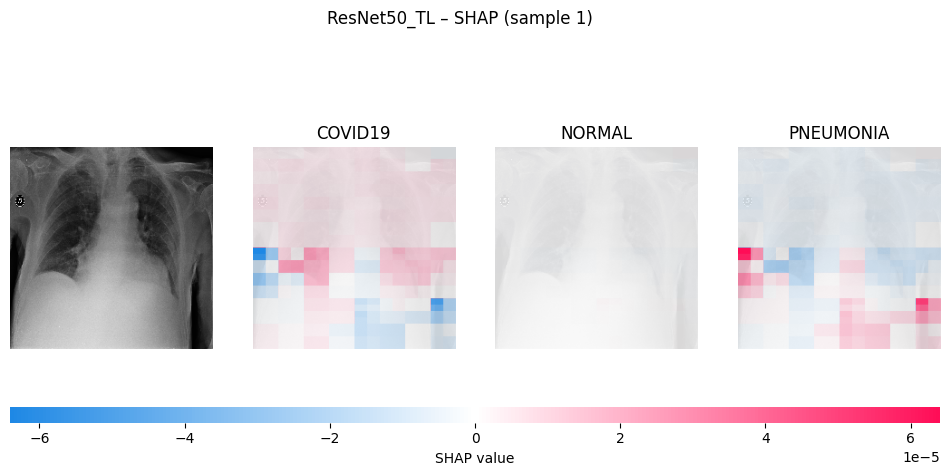

Saved: artifacts\shap\ResNet50_TL_shap_1.png


<Figure size 640x480 with 0 Axes>

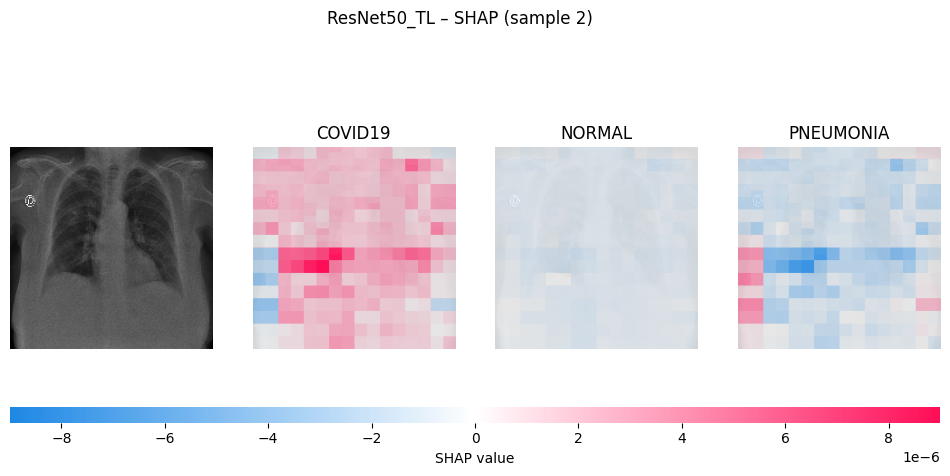

Saved: artifacts\shap\ResNet50_TL_shap_2.png


<Figure size 640x480 with 0 Axes>

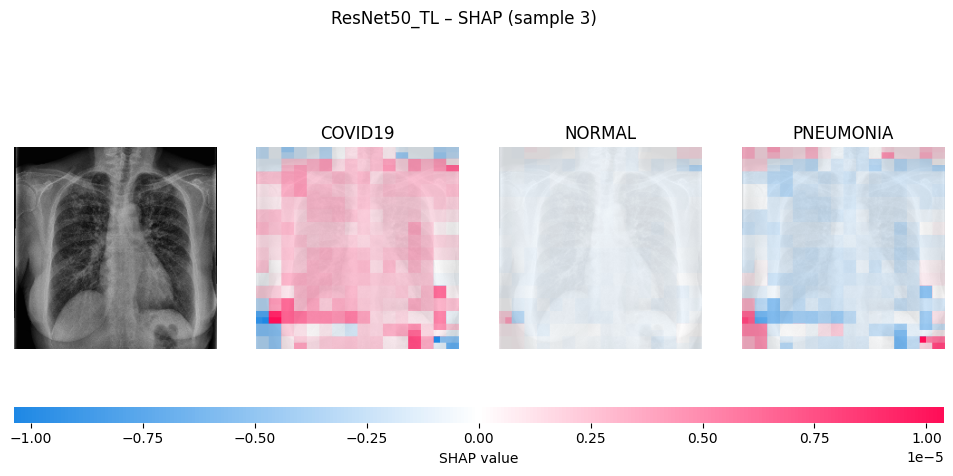

Saved: artifacts\shap\ResNet50_TL_shap_3.png


<Figure size 640x480 with 0 Axes>

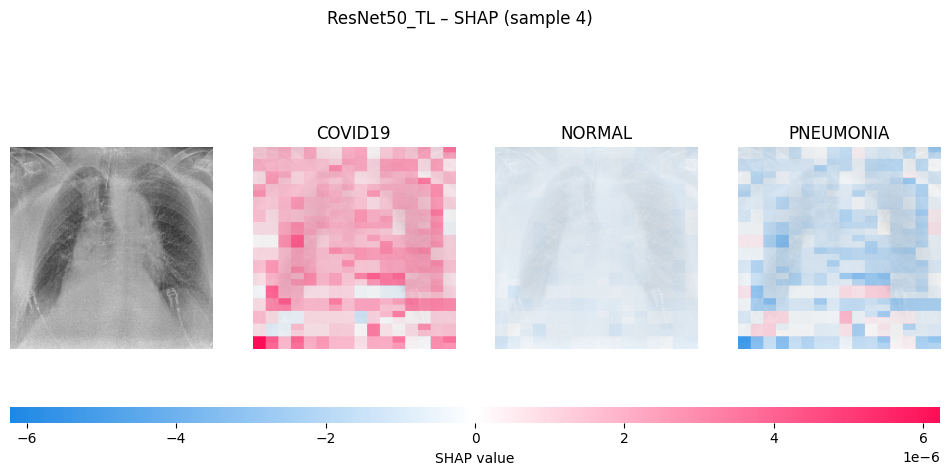

Saved: artifacts\shap\ResNet50_TL_shap_4.png


<Figure size 640x480 with 0 Axes>

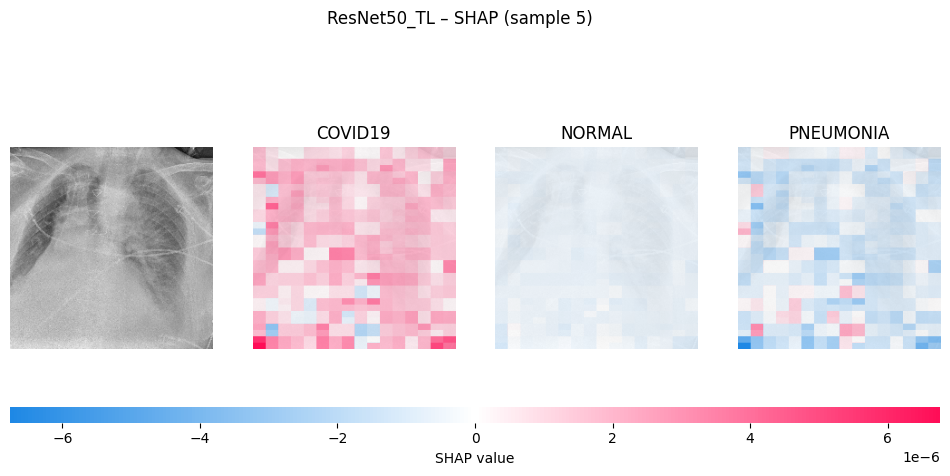

Saved: artifacts\shap\ResNet50_TL_shap_5.png

All done ✅ — artifacts saved under: artifacts


In [ ]:
run_shap_partition_multiclass(resnet, raw_images, model_name="ResNet50_TL", max_images=6, max_evals=800)

print("\nAll done ✅ — artifacts saved under:", ARTIFACTS_DIR)